[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/025_mlp_framework/mlp_framework.ipynb)

# El Perceptrón Multicapa - Nuestro propio Framework

En el [post](https://sensioai.com/blog/024_mlp_clasificacion) anterior completamos una implementación del Perceptrón Multicapa capaz de llevar a cabo tareas de `regresión` y `clasificación`. Sin embargo, esta implementación tiene muchas limitaciones. Por ejemplo, sólo sirve para un perceptrón multicapa con una capa oculta con funciones de activación de tipo `relu`, entre otras. Aún así, programar todos los elementos envueltos en un arquitectura en concreto es muy útil para entender qué está pasando dentro de la `red neuronal` en todo momento. En este post vamos a mejorar la implementación para resolver estas limitaciones, haciendo nuestro propio framework inspirado en [Pytorch](https://pytorch.org/).

## Diseño de la API

Nuestro objetivo es el de ser capaces de resolver los problemas que hemos visto hasta ahora con una interfaz similar a la siguiente:

In [ ]:
D_in, H, D_out = 2, 3, 2

mlp = MLP([
    Linear(D_in, H),
    ReLU(),
    Linear(H, D_out)
])

optimizer = SGD(mlp, lr=0.1)
loss = CrossEntropy(mlp)

epochs = 100
for e in range(epochs):
  for batch in batches:
    y_pred = mlp(x)    
    loss(y_pred, y)
    loss.backward()    
    optimizer.update()

En primer lugar, queremos definir nuestro `MLP` como una secuencia de capas, las cuales pasaremos como una lista a la clase `MLP`. Como puedes ver, de esta manera, podemos usar diferentes funciones de activación simplemente cambiando la clase utilizada. Después, definiremos los objetos `optimizer` y `loss` como clases particulares de manera que podamos, de manera totalmente transparente, utilizar diferentes funciones de pérdida o algoritmos de optimización simplemente cambiando la clase en cuestión. Por último, en el bucle de entrenamiento, querremos ser capaces de calcular la salida del modelo, gradientes y actualizar los pesos de manera automática. Vamos a ver cómo conseguirlo en las siguientes secciones.

## MLP y Capas

Vamos a empezar definiendo nuestra clase `MLP`. Como ya hemos comentado, esta clase estará formada por una lista de capas y simplemente se encargará de calcular la salida del modelo aplicando cada capa de manera secuencial.

In [30]:
class MLP:
    def __init__(self, layers):
        # el MLP es una lista de capas
        self.layers = layers

    def __call__(self, x):
        # calculamos la salida del modelo aplicando
        # cada capa de manera secuencial
        for layer in self.layers:
            x = layer(x)
        return x

Ahora definimos las diferentes capas que necesitamos. En primer lugar tendremos una clase base que contendrá los elementos y funcionalidad común de cada capa. Esta clase contendrá una lista con los parámetros entrenables de la capa y sus gradientes.

In [31]:
class Layer():
    def __init__(self):
        self.params = []
        self.grads = []

    def __call__(self, x):
        # por defecto, devolver los inputs
        # cada capa hará algo diferente aquí
        return x

    def backward(self, grad):
        # cada capa, calculará sus gradientes
        # y los devolverá para las capas siguientes
        return grad

    def update(self, params):
        # si hay parámetros, los actualizaremos
        # con lo que nos de el optimizer
        return

Ahora podemos definir las diferentes capas que utilizaremos. Hasta ahora sólo hemos visto la capa lineal y diferentes funciones de activación.

In [32]:
class Linear(Layer):
    """ Capa Perceptron """
    def __init__(self, d_in, d_out):
        # pesos de la capa
        self.w = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(d_in+d_out)),
                                  size=(d_in, d_out))
        self.b = np.zeros(d_out)

    def __call__(self, x):
        self.x = x
        self.params = [self.w, self.b]
        # salida del preceptrón
        return np.dot(x, self.w) + self.b    
    
    def backward(self, grad_output):
        # gradientes para la capa siguiente (BACKPROP)
        grad = np.dot(grad_output, self.w.T)
        self.grad_w = np.dot(self.x.T, grad_output)
        # gradientes para actualizar pesos
        self.grad_b = grad_output.mean(axis=0)*self.x.shape[0]
        self.grads = [self.grad_w, self.grad_b]
        return grad

    def update(self, params):
        self.w, self.b = params

In [33]:
class ReLU(Layer):
    """ Capa Funcion de activacion ReLU"""
    def __call__(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        grad = self.x > 0
        return grad_output*grad
    
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

class Sigmoid(Layer):    
    def __call__(self, x):
        self.x = x
        return sigmoid(x)

    def backward(self, grad_output):
        grad = sigmoid(self.x)*(1 - sigmoid(self.x))
        return grad_output*grad

## Optimizador

De momento solo conocemos un algoritmo de optimización, el `descenso por gradiente`. En este algoritmo, iteraremos por todas las capas del `MLP` actualizando los parámetros.

In [34]:
class SGD():
    def __init__(self, net, lr):
        self.net = net
        self.lr = lr

    def update(self):
        for layer in self.net.layers:
            layer.update([
                params - self.lr*grads
                for params, grads in zip(layer.params, layer.grads)
            ])

Puedes probar algoritmos de optimización diferentes simplemente creando una nueva clase con una regla distinta para la actualización de los pesos. En futuros posts exploraremos optimizadores alternativos. Esta clase sólo se encarga de aplicar los gradientes en una manera determinada para actualizar los pesos, el cálculo de los gradientes depende de cada capa en concreto.

## Funciones de pérdida

Del mismo modo que hemos hecho para las capas, vamos a implementar una clase base para calcular funciones de pérdida con la funcionalidad común y después tendremos clases particulares para las diferentes funciones de pérdida que conocemos.

In [35]:
class Loss():
    def __init__(self, net):
        self.net = net

    def backward(self):
        # derivada de la loss function con respecto 
        # a la salida del MLP
        grad = self.grad_loss()
        # BACKPROPAGATION
        for layer in reversed(self.net.layers):
            grad = layer.backward(grad)
            
class MSE(Loss):
    def __call__(self, output, target):
        self.output, self.target = output, target.reshape(output.shape)
        loss = np.mean((self.output - self.target)**2)
        return loss.mean()

    def grad_loss(self):
        return self.output -  self.target
    
class BCE(Loss):
    def __call__(self, output, target):
        self.output, self.target = output, target.reshape(output.shape)
        loss = - np.mean(self.target*np.log(self.output) - (1 - self.target)*np.log(1 - self.output))
        return loss.mean()

    def grad_loss(self):
        return self.output -  self.target
            
class CrossEntropy(Loss):
    def __call__(self, output, target):
        self.output, self.target = output, target
        logits = output[np.arange(len(output)), target]
        loss = - logits + np.log(np.sum(np.exp(output), axis=-1))
        loss = loss.mean()
        return loss

    def grad_loss(self):
        answers = np.zeros_like(self.output)
        answers[np.arange(len(self.output)), self.target] = 1
        return (- answers + softmax(self.output)) / self.output.shape[0]

La clase que utilicemos como función de pérdida tendrá la responsabilidad de llevar a cabo el algoritmo de `backpropagation`, propagando los gradientes desde la última capa hasta la primera para que, más tarde, el optimizador pueda actualizar los pesos.

## Probando la implementación

En este punto tenemos todas las clases que necesitamos para resolver nuestros casos de interés.

### Regresión

Empezamos con el caso de la regresión (en este caso directamente no lineal).

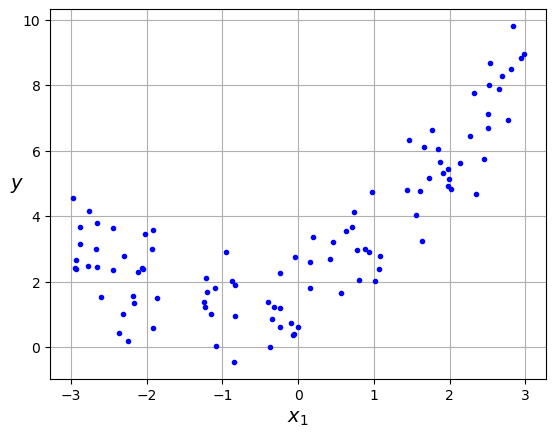

In [36]:
import numpy as np
import matplotlib.pyplot as plt

m = 100
X = 6 * np.random.rand(m, 1) - 3
Y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, Y, "b.")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

Para ello usamos una función de activación de tipo `MSE` con una función de activación lineal en la última capa.

In [37]:
D_in, H, D_out = 1, 3, 1
mlp = MLP([
    Linear(D_in, H),
    ReLU(),
    Linear(H, D_out)
])

optimizer = SGD(mlp, lr=0.01)
loss = MSE(mlp)

epochs = 100
batch_size = 10

batches = len(X) // batch_size
log_each = 10
l = []
for e in range(1,epochs+1):
    _l = []
    for b in range(batches):
        x = X[b*batch_size:(b+1)*batch_size]
        y = Y[b*batch_size:(b+1)*batch_size] 
        y_pred = mlp(x)    
        _l.append(loss(y_pred, y))
        loss.backward()    
        optimizer.update()
    l.append(np.mean(_l))
    if not e % log_each:
        print(f'Epoch {e}/{epochs}, Loss: {np.mean(l):.4f}')

Epoch 10/100, Loss: 1.4167
Epoch 20/100, Loss: 1.2250
Epoch 30/100, Loss: 1.1594
Epoch 40/100, Loss: 1.1258
Epoch 50/100, Loss: 1.1051
Epoch 60/100, Loss: 1.0910
Epoch 70/100, Loss: 1.0807
Epoch 80/100, Loss: 1.0727
Epoch 90/100, Loss: 1.0663
Epoch 100/100, Loss: 1.0611


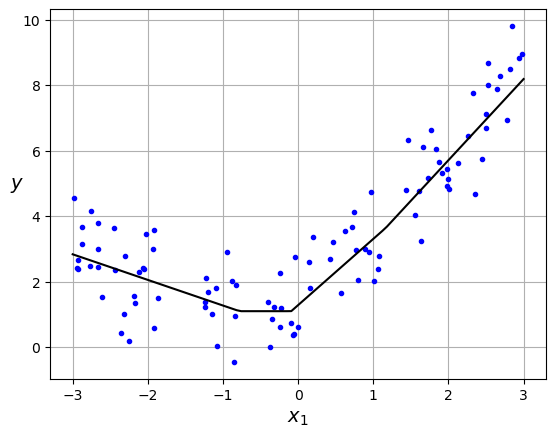

In [38]:
x_new = np.linspace(-3, 3, 100)
x_new = x_new.reshape(len(x_new),1)
y_pred = mlp(x_new)
    
plt.plot(X, Y, "b.")
plt.plot(x_new, y_pred, "-k")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

¿Y si queremos utilizar un `MLP` con más capas y más neuronas? Simplemente las añadimos a la lista.

In [39]:
D_in, H, D_out = 1, 10, 1
# añadimos más capas
mlp = MLP([
    Linear(D_in, H),
    ReLU(),
    Linear(H, H),
    ReLU(),
    Linear(H, H),
    ReLU(),
    Linear(H, D_out)
])

optimizer = SGD(mlp, lr=0.01)
loss = MSE(mlp)

epochs = 100
batch_size = 10

batches = len(X) // batch_size
log_each = 10
l = []
for e in range(1,epochs+1):
    _l = []
    for b in range(batches):
        x = X[b*batch_size:(b+1)*batch_size]
        y = Y[b*batch_size:(b+1)*batch_size] 
        y_pred = mlp(x)    
        _l.append(loss(y_pred, y))
        loss.backward()    
        optimizer.update()
    l.append(np.mean(_l))
    if not e % log_each:
        print(f'Epoch {e}/{epochs}, Loss: {np.mean(l):.4f}')

Epoch 10/100, Loss: 3.5444
Epoch 20/100, Loss: 2.7513
Epoch 30/100, Loss: 2.3444
Epoch 40/100, Loss: 2.0769
Epoch 50/100, Loss: 1.8971
Epoch 60/100, Loss: 1.7790
Epoch 70/100, Loss: 1.6930
Epoch 80/100, Loss: 1.6291
Epoch 90/100, Loss: 1.5777
Epoch 100/100, Loss: 1.5346


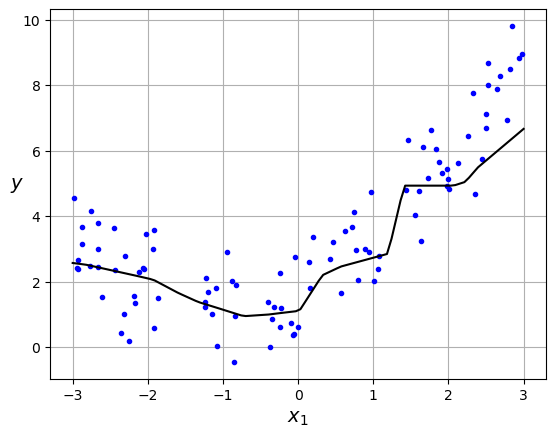

In [40]:
x_new = np.linspace(-3, 3, 100)
x_new = x_new.reshape(len(x_new),1)
y_pred = mlp(x_new)
    
plt.plot(X, Y, "b.")
plt.plot(x_new, y_pred, "-k")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

Nuestro framework es capaz de llevar a cabo la tarea de regresión, y si ahora queremos llevar a cabo tareas de clasificación es tan sencillo como cambiar la función de pérdida y de activación en la clase `MLP`.

### Clasificación Binaria

Vamos a probar nuestro framework para clasificación con el dataset *Iris*.

In [41]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
Y = iris.target

# normalización datos
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_norm = (X - X_mean) / X_std

X.shape, Y.shape

((150, 2), (150,))

In [42]:
Y = (iris.target == 0).astype(np.int32)

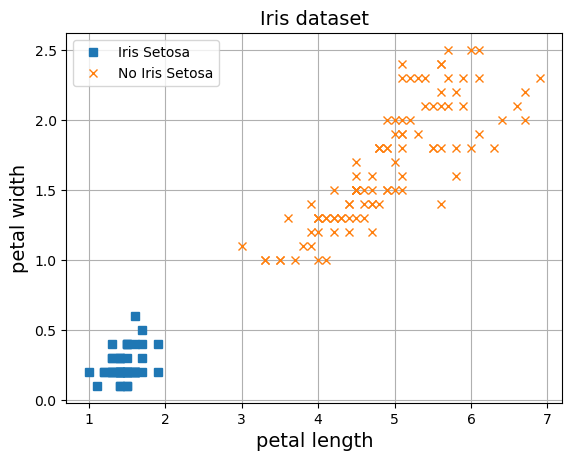

In [43]:
plt.plot(X[Y==1, 0], X[Y==1, 1], 's', label="Iris Setosa")
plt.plot(X[Y==0, 0], X[Y==0, 1], 'x', label="No Iris Setosa")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

Para llevar a cabo la tarea de clasificación binaria, usamos una función de activación `Sigmoid` en la última capa junto a la función de activación `Binary Cross Entropy`.

In [44]:
D_in, H, D_out = 2, 3, 1
mlp = MLP([
    Linear(D_in, H),
    ReLU(),
    Linear(H, D_out),
    Sigmoid()
])

optimizer = SGD(mlp, lr=0.01)
loss = BCE(mlp)

epochs = 100
batch_size = 10

batches = len(X) // batch_size
log_each = 10
l = []
for e in range(1,epochs+1):
    _l = []
    for b in range(batches):
        x = X_norm[b*batch_size:(b+1)*batch_size]
        y = Y[b*batch_size:(b+1)*batch_size] 
        y_pred = mlp(x)    
        _l.append(loss(y_pred, y))
        loss.backward()    
        optimizer.update()
    l.append(np.mean(_l))
    if not e % log_each:
        print(f'Epoch {e}/{epochs}, Loss: {np.mean(l):.4f}')

Epoch 10/100, Loss: -0.2682
Epoch 20/100, Loss: -0.2049
Epoch 30/100, Loss: -0.1683
Epoch 40/100, Loss: -0.1438
Epoch 50/100, Loss: -0.1260
Epoch 60/100, Loss: -0.1126
Epoch 70/100, Loss: -0.1020
Epoch 80/100, Loss: -0.0934
Epoch 90/100, Loss: -0.0863
Epoch 100/100, Loss: -0.0802


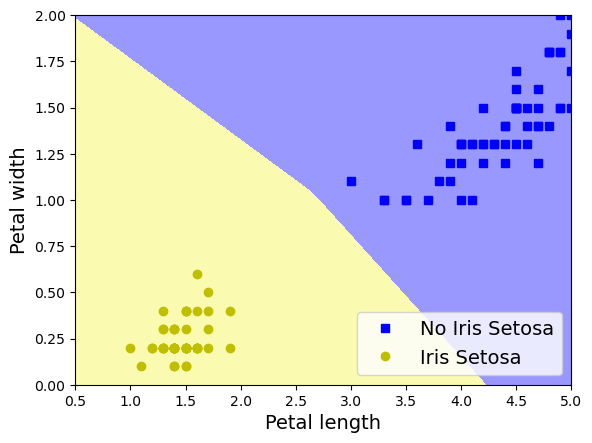

In [45]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

axes = [0.5, 5, 0, 2]
label="Iris Setosa"
x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - X_mean) / X_std 
y_predict = mlp(X_new)
zz = y_predict.reshape(x0.shape)
plt.plot(X[Y==0, 0], X[Y==0, 1], "bs", label=f"No {label}")
plt.plot(X[Y==1, 0], X[Y==1, 1], "yo", label=label)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)
plt.show()

Vamos a entrenar un `MLP` en el caso de la clasificación de las flores *Iris Versicolor*, una clase que no es linealmente separable, con más capas y neuronas.

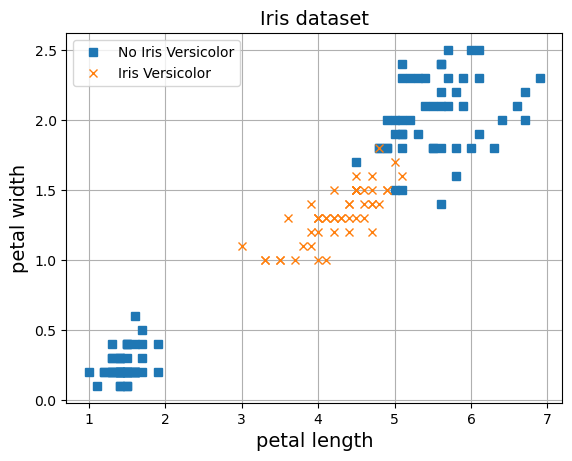

In [46]:
Y = (iris.target == 1).astype(np.int32)

plt.plot(X[Y==0, 0], X[Y==0, 1], 's', label="No Iris Versicolor")
plt.plot(X[Y==1, 0], X[Y==1, 1], 'x', label="Iris Versicolor")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

In [47]:
D_in, H, D_out = 2, 100, 1
mlp = MLP([
    Linear(D_in, H),
    ReLU(),
    Linear(H, H),
    ReLU(),
    Linear(H, H),
    ReLU(),
    Linear(H, D_out),
    Sigmoid()
])

optimizer = SGD(mlp, lr=0.01)
loss = BCE(mlp)

epochs = 100
batch_size = 10

batches = len(X) // batch_size
log_each = 10
l = []
for e in range(1,epochs+1):
    _l = []
    for b in range(batches):
        x = X_norm[b*batch_size:(b+1)*batch_size]
        y = Y[b*batch_size:(b+1)*batch_size] 
        y_pred = mlp(x)    
        _l.append(loss(y_pred, y))
        loss.backward()    
        optimizer.update()
    l.append(np.mean(_l))
    if not e % log_each:
        print(f'Epoch {e}/{epochs}, Loss: {np.mean(l):.4f}')

Epoch 10/100, Loss: 0.0079
Epoch 20/100, Loss: 0.0342
Epoch 30/100, Loss: 0.0340
Epoch 40/100, Loss: 0.0305
Epoch 50/100, Loss: 0.0272
Epoch 60/100, Loss: 0.0245
Epoch 70/100, Loss: 0.0223
Epoch 80/100, Loss: 0.0206
Epoch 90/100, Loss: 0.0191
Epoch 100/100, Loss: 0.0179


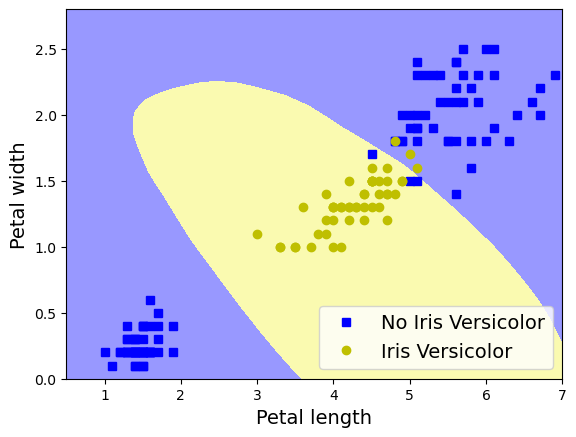

In [48]:
axes = [0.5, 7, 0, 2.8]
label="Iris Versicolor"
x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - X_mean) / X_std 
y_predict = mlp(X_new)
zz = y_predict.reshape(x0.shape)
plt.plot(X[Y==0, 0], X[Y==0, 1], "bs", label=f"No {label}")
plt.plot(X[Y==1, 0], X[Y==1, 1], "yo", label=label)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)
plt.show()

Como puedes ver, nuestro framework ahora es flexible a la vez que funcional.

### Clasificación Multiclase

Por último, resolvemos el caso de clasificación multiclase.

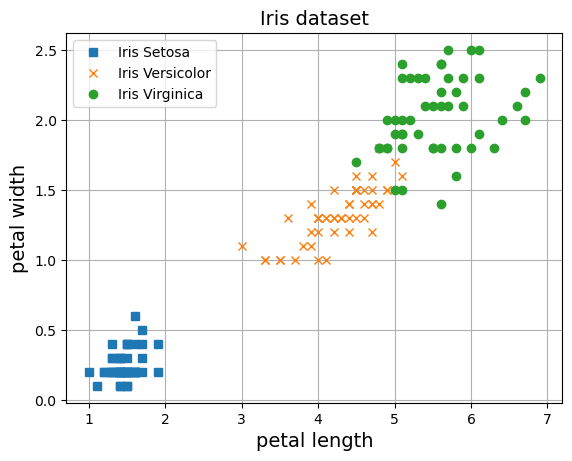

In [49]:
Y = iris.target

plt.plot(X[Y==0, 0], X[Y==0, 1], 's', label="Iris Setosa")
plt.plot(X[Y==1, 0], X[Y==1, 1], 'x', label="Iris Versicolor")
plt.plot(X[Y==2, 0], X[Y==2, 1], 'o', label="Iris Virginica")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

Para ello ya sabemos que tenemos que usar la función de pérdida `CrossEntropy` con función de activación lineal en la última capa.

In [50]:
D_in, H, D_out = 2, 100, 3
mlp = MLP([
    Linear(D_in, H),
    ReLU(),
    Linear(H, H),
    ReLU(),
    Linear(H, H),
    ReLU(),
    Linear(H, D_out)
])

optimizer = SGD(mlp, lr=0.02)
loss = CrossEntropy(mlp)

epochs = 100
batch_size = 10

batches = len(X) // batch_size
log_each = 10
l = []
for e in range(1,epochs+1):
    _l = []
    for b in range(batches):
        x = X_norm[b*batch_size:(b+1)*batch_size]
        y = Y[b*batch_size:(b+1)*batch_size] 
        y_pred = mlp(x)    
        _l.append(loss(y_pred, y))
        loss.backward()    
        optimizer.update()
    l.append(np.mean(_l))
    if not e % log_each:
        print(f'Epoch {e}/{epochs}, Loss: {np.mean(l):.4f}')

Epoch 10/100, Loss: 0.6049
Epoch 20/100, Loss: 0.4301
Epoch 30/100, Loss: 0.3365
Epoch 40/100, Loss: 0.2804
Epoch 50/100, Loss: 0.2439
Epoch 60/100, Loss: 0.2184
Epoch 70/100, Loss: 0.1997
Epoch 80/100, Loss: 0.1854
Epoch 90/100, Loss: 0.1742
Epoch 100/100, Loss: 0.1650


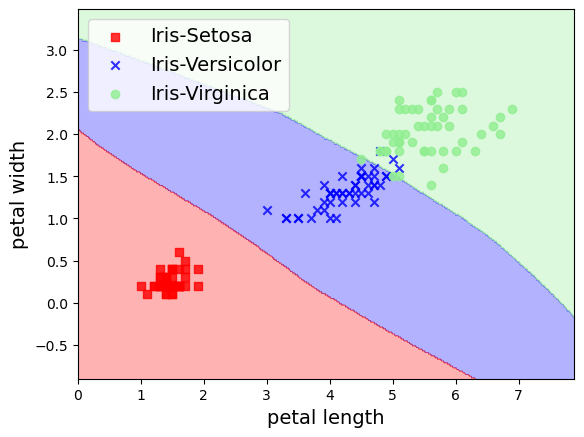

In [52]:
resolution=0.02
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(Y))])

# plot the decision surface
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                       np.arange(x2_min, x2_max, resolution))
X_new = (np.array([xx1.ravel(), xx2.ravel()]).T - X_mean)/X_std
Z = mlp(X_new)
Z = np.argmax(softmax(Z), axis=1) 
Z = Z.reshape(xx1.shape)
plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
plt.xlim(xx1.min(), xx1.max())
plt.ylim(xx2.min(), xx2.max())
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
classes = ["Iris-Setosa", "Iris-Versicolor", "Iris-Virginica"]
for idx, cl in enumerate(np.unique(Y)):
    plt.scatter(x=X[Y == cl, 0], 
                y=X[Y == cl, 1],
                alpha=0.8, 
                c=colors[idx],
                marker=markers[idx], 
                label=classes[cl], 
                #edgecolor='black'
                facecolor='none')
plt.legend(loc='upper left', fontsize=14)
plt.show()

## Resumen

En este post hemos visto como podemos implementar nuestro propio framework de perceptrón multicapa. Las ideas expuestas son muy similares a las utilizadas internamente por frameworks de `redes neuronales` como `Pytorch` o `Tensorflow`, lo cual nos permitirá conocer en detalle como funcionan estos frameworks a la hora de trabajar con arquitecturas más complicadas. Nuestro framework es flexible, ya que con la misma interfaz es capaz de llevar a cabo las diferentes tareas y de manera muy sencilla podemos probar diferentes arquitecturas de `MLP` con más o menos capas, diferentes funciones de pérdida y de activación, etc. En este [post](https://sensioai.com/blog/017_clasificacion_multiclase) utilizamos el dataset MNIST para clasificación de imágenes, ¿te ves capaz de utilizar nuestro framework para esta tarea?